In [156]:
import sys
import os
from os.path import join
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ipywidgets import interact_manual,interact, fixed
import math
import cv2


# Preliminary Uncertainty Tests

Functions

In [2]:
def extract_tensors(path, tensor_name):
    '''extracts tensors from path (as created when any uncertainty test is ran'''
    # get only the correct folders
    folders = []
    for sub_path in os.listdir(path):
        if sub_path.startswith('image'):
            folders.append( sub_path)
    
    # extract tensors
    all_images = {}
    for im_folder in folders:
        im_path = join(path, im_folder)
        # save the tensors in their own dict according to name before
        for tensor in os.listdir(im_path):
            if tensor == tensor_name:
                tensor_path = join(im_path, tensor)
                all_images[int(im_folder.split('_')[-1])] = torch.load(tensor_path, map_location = 'cpu')
    return all_images


In [3]:
def display_tensor(tensor_dict:dict, im_dict:dict, target_dict:dict, im_num: int = 0 , vmin:float = 0, vmax: float = 1):
    fig, ax = plt.subplots(1,3, figsize = (18, 12))
    im1 = ax[0].imshow(im_dict[im_num], cmap = 'gray',)
    im2 = ax[1].imshow(tensor_dict[im_num][0][0].numpy(), cmap = 'gray', vmin = vmin, vmax = vmax)
    im3 = ax[2].imshow(target_dict[im_num], cmap = 'gray', )
    ax[0].set_title('Orig')
    ax[1].set_title('Expected')
    ax[2].set_title('GT')
    fig.show()
    print('Min: ' ,torch.min(tensor_dict[im_num][0][0]).item())
    print('Max: ' ,torch.max(tensor_dict[im_num][0][0]).item())

In [4]:
def compare_tensor(tensor_dict1:dict, tensor_dict2:dict, im_dict:dict, target_dict:dict, im_num: int = 0 , vmin:float = 0, vmax: float = 1):
    fig, ax = plt.subplots(1,4, figsize = (30, 28))
    im1 = ax[0].imshow(im_dict[im_num], cmap = 'gray',)
    im2 = ax[1].imshow(tensor_dict1[im_num][0][0].numpy(), cmap = 'gray', vmin = vmin, vmax = vmax)
    im3 = ax[2].imshow(tensor_dict2[im_num][0][0].numpy(), cmap = 'gray', vmin = vmin, vmax = vmax)
    im4 = ax[3].imshow(target_dict[im_num], cmap = 'gray', )
    ax[0].set_title('Orig')
    ax[1].set_title('Independent')
    ax[2].set_title('Dependent')
    ax[3].set_title('GT')
    fig.show()
    print(f'Min: I:{torch.min(tensor_dict1[im_num][0][0]).item():7.5f} D: {torch.max(tensor_dict2[im_num][0][0]).item():7.5f}', )
    print(f'Min: I:{torch.max(tensor_dict1[im_num][0][0]).item():7.5f} D: {torch.max(tensor_dict2[im_num][0][0]).item():7.5f}', )

In [5]:
def pseudo_anim(tensor_dict: dict, val_num: int = 0 , im_num: int = 0 ):
    ''' creates an animated gif using images
    
    output:
    creates a gif'''

    fig, ax = plt.subplots(1,1, figsize = (8, 8))
    ax.imshow(tensor_dict[val_num][im_num][0][0].numpy(), cmap = 'gray', vmin = 0, vmax = 1)
    fig.show()
    

Root Directory - change if different (make sure corresponding internal files are also changed)

In [6]:
root = '../results/base_model'

print(os.listdir(root))

['model_info', 'lightning_logs', 'test_statistics', 'dropblock_uncertainty_i', 'rotational_uncertainty', 'test_statistics_32_32', 'test_statistics_128_128', 'test_statistics_64_64', 'test_statistics_256_256', 'dropblock_uncertainty_d']


Validation Images

In [7]:
val_root_images = '../augmented_data/val/images'
orig = {}
# retrieves validation images as grayscale
for im in os.listdir(val_root_images):
    orig[int(im.split('_')[0])] = np.array(Image.open(join(val_root_images, im)).convert('L'))

val_root_targets = '../augmented_data/val/targets'
targets = {}
for im in os.listdir(val_root_targets):
    targets[int(im.split('_')[0])] = np.array(Image.open(join(val_root_targets, im)).convert('L'))

mask_root_targets = '../augmented_data/val/masks'
masks = {}
for im in os.listdir(mask_root_targets):
    masks[int(im.split('_')[0])] = np.array(Image.open(join(mask_root_targets, im)).convert('L'))


# Monte Carlo Dropblock - Dependent Channels

In [8]:
DB_d_path = join(root, 'dropblock_uncertainty_d/tensors')

DB_d_mean_tensors = extract_tensors(DB_d_path, 'mean.pt')
DB_d_tensors = extract_tensors(DB_d_path, 'std.pt')
DB_d_extra_tensors = extract_tensors(DB_d_path, 'tensors.pt')

Means

In [9]:
x = interact(display_tensor,
        tensor_dict=fixed(DB_d_mean_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(DB_d_mean_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01))

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

STD

In [10]:
x = interact(display_tensor,
        tensor_dict=fixed(DB_d_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(DB_d_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

View 25 Examples

In [11]:
x = interact(pseudo_anim, 
                tensor_dict = fixed(DB_d_extra_tensors),
                val_num =  (0,len(DB_d_extra_tensors) -1),
                im_num = (0, len(DB_d_extra_tensors[0]) -1))

interactive(children=(IntSlider(value=0, description='val_num', max=5), IntSlider(value=0, description='im_num…

# Monte Carlo Dropblock = Independent

In [12]:
DB_i_path = join(root, 'dropblock_uncertainty_i/tensors')

DB_i_mean_tensors = extract_tensors(DB_i_path, 'mean.pt')
DB_i_tensors = extract_tensors(DB_i_path, 'std.pt')
DB_i_extra_tensors = extract_tensors(DB_i_path, 'tensors.pt')

Mean

In [13]:
x = interact(display_tensor,
        tensor_dict=fixed(DB_i_mean_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(DB_i_mean_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

STD

In [14]:
x = interact(display_tensor,
        tensor_dict=fixed(DB_i_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(DB_i_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

View 25 Tensors

In [15]:
interact(pseudo_anim, 
                tensor_dict = fixed(DB_i_extra_tensors),
                val_num =  (0,len(DB_i_extra_tensors) -1),
                im_num = (0, len(DB_i_extra_tensors[0]) -1))

interactive(children=(IntSlider(value=0, description='val_num', max=5), IntSlider(value=0, description='im_num…

<function __main__.pseudo_anim(tensor_dict: dict, val_num: int = 0, im_num: int = 0)>

# Independent vs Dependent

Mean

In [16]:
x = interact(compare_tensor,
        tensor_dict1=fixed(DB_i_mean_tensors),
        tensor_dict2=fixed(DB_d_mean_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(DB_i_mean_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

STD

In [17]:
x = interact(compare_tensor,
        tensor_dict1=fixed(DB_i_tensors),
        tensor_dict2=fixed(DB_d_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(DB_i_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

# Rotational Uncertainty

In [18]:
rotation_path = join(root, 'rotational_uncertainty')

rotation_mean_tensors = extract_tensors(rotation_path, 'mean.pt')
rotation_tensors = extract_tensors(rotation_path, 'std.pt')
rotation_extra_tensors = extract_tensors(rotation_path, 'tensors.pt')

In [19]:
rotation_mean_tensors[0].shape

torch.Size([1, 1, 584, 565])

Mean

In [20]:
x = interact(display_tensor,
        tensor_dict=fixed(rotation_mean_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(rotation_mean_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

STD

In [21]:
x = interact(display_tensor,
        tensor_dict=fixed(rotation_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(rotation_tensors) -1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=5), FloatSlider(value=0.0, description='vmi…

View 25 Images

In [22]:
x = interact(pseudo_anim, 
                tensor_dict = fixed(rotation_extra_tensors),
                val_num =  (0,len(rotation_extra_tensors) -1),
                im_num = (0, len(rotation_extra_tensors[0]) -1))

interactive(children=(IntSlider(value=0, description='val_num', max=5), IntSlider(value=0, description='im_num…

# Testing Function

In [23]:

def visualize_magnitudes(
                tensor_dicts,
                im_dict,
                target_dict,
                im_num = 0,
                vmin = 0,
                vmax = 1):
        arr = len(tensor_dicts) + 2

        cols = 4
        rows = math.ceil(arr / 4)

        fig, axes = plt.subplots(rows, cols, figsize = (8 * cols, 8*rows))

        axes = axes.flatten()

        axes[0].imshow(im_dict[im_num], cmap = 'gray',)
        axes[0].set_title('Input Image')
        for model_id, (model_name, model_dict) in enumerate(tensor_dicts.items()):
                model_id = model_id + 1
                axes[model_id].imshow(model_dict[im_num][0][0].numpy(), cmap = 'gray', vmin = vmin, vmax = vmax)
                axes[model_id].set_title(model_name)
        axes[-1].imshow(target_dict[im_num], cmap = 'gray',)
        axes[-1].set_title('GT Image')
        
        fig.show()

In [24]:
def calculate_magnitudes(std_dicts, mean_dicts):

        cols = ['model_name', 'im_num', 'min', 'max','mean', 'std',  'mean_thresholded_0.01', 'std_thresholded_0.01','mean_thresholded_0.001','std_thresholded_0.001','mean_thresholded_0','std_thresholded_0',]
        data = dict(zip(cols, [[] for i in range(len(cols))]))
        data2 = dict(zip(cols, [[] for i in range(len(cols))]))

        for model_id, (model_name, model_dict) in enumerate(std_dicts.items()):
                for im_num in model_dict:
                        
                        std_data = model_dict[im_num][0][0].flatten()
                        data['model_name'].append(model_name)
                        data['im_num'].append(im_num)
                        data['min'].append(torch.min(std_data).item())
                        data['max'].append(torch.max(std_data).item())
                        data['mean'].append(torch.mean(std_data).item())
                        data['std'].append(torch.std(std_data).item())
                        data['mean_thresholded_0.01'].append(torch.mean(std_data[std_data > 0.01]).item())
                        data['std_thresholded_0.01'].append(torch.std(std_data[std_data > 0.01]).item())
                        data['mean_thresholded_0.001'].append(torch.mean(std_data[std_data > 0.001]).item())
                        data['std_thresholded_0.001'].append(torch.std(std_data[std_data > 0.001]).item())
                        data['mean_thresholded_0'].append(torch.mean(std_data[std_data > 0]).item())
                        data['std_thresholded_0'].append(torch.std(std_data[std_data > 0]).item())

        for model_id, (model_name, model_dict) in enumerate(mean_dicts.items()):
                for im_num in model_dict:
                        mean_data = model_dict[im_num][0][0].flatten()
                        data2['model_name'].append(model_name)
                        data2['im_num'].append(im_num)
                        data2['min'].append(torch.min(mean_data).item())
                        data2['max'].append(torch.max(mean_data).item())
                        data2['mean'].append(torch.mean(mean_data).item())
                        data2['std'].append(torch.std(mean_data).item())
                        data2['mean_thresholded_0.01'].append(torch.mean(mean_data[mean_data > 0.01]).item())
                        data2['std_thresholded_0.01'].append(torch.std(mean_data[mean_data > 0.01]).item())
                        data2['mean_thresholded_0.001'].append(torch.mean(mean_data[mean_data > 0.001]).item())
                        data2['std_thresholded_0.001'].append(torch.std(mean_data[mean_data > 0.001]).item())
                        data2['mean_thresholded_0'].append(torch.mean(mean_data[mean_data > 0]).item())
                        data2['std_thresholded_0'].append(torch.std(mean_data[mean_data > 0]).item())
        
        return pd.DataFrame(data, columns = cols), pd.DataFrame(data2, columns = cols)

In [25]:
def display_std_hist(std_dict, key = 'BM-1', im_num = 0, threshold = .01):
    data = std_dict[key][im_num].flatten()
    data = data[data > threshold]
    print("Data size:", len(data))
    plt.hist(data)

In [26]:
def display_agg_std_hist(std_dict, key = 'BM-1', threshold = .01):
    data = torch.cat(list(std_dict[key].values())).flatten()
    data = data[data > threshold]
    print("Data size:", len(data))
    plt.hist(data, bins = 'auto')

In [27]:
def add_data(path, name, df):
    temp = pd.read_csv(path, index_col = 0)
    temp['name'] = name
    return pd.concat([df, temp])

# Test 1 - equivalent data, rf trained with no knowledge of higher fidelity

In [28]:
import pandas as pd

In [161]:
all_data = pd.DataFrame()
mean_db_tensors = {}
std_db_tensors = {}
mean_rot_tensors = {}
std_rot_tensors = {}
seg_tensors = {}


In [162]:
models = 'BM-1 BM-2 BM-3 MF-1 MF-2 LF-1 LF-2 LF-3 LF-4 LF-5 LF-6'.split()

In [163]:
drive_root = '../results/DRIVE/'
#models
for model_id in models:
    path = join(drive_root, model_id)
    # reg
    all_data = add_data(join(path, 'statistics/val_images/metrics.csv'), name = model_id, df =  all_data)
    # db
    all_data = add_data(join(path, 'dropblock_uncertainty/statistics/val_images/metrics.csv'), name = f'{model_id}_DB', df = all_data)
    seg_tensors[model_id] = extract_tensors(join(path, 'statistics/val_images/tensors'), 'segmentation.pt')
    mean_db_tensors[model_id] = extract_tensors(join(path, 'dropblock_uncertainty/tensors'), 'mean.pt')
    std_db_tensors[model_id] = extract_tensors(join(path, 'dropblock_uncertainty/tensors'), 'std.pt')
    mean_rot_tensors[model_id] = extract_tensors(join(path, 'rotation_uncertainty'), 'mean.pt')
    std_rot_tensors[model_id] = extract_tensors(join(path, 'rotation_uncertainty'), 'std.pt')

In [164]:
all_data.groupby(['name']).mean()

,F1_Vessel,AUROC_Vessel,Accuracy_Vessel
name,,,
BM-1,0.805617,0.978334,0.953049
BM-1_DB,0.802173,0.978961,0.953915
BM-2,0.803296,0.976341,0.952435
BM-2_DB,0.792923,0.976687,0.952650
BM-3,0.784428,0.968870,0.947088
BM-3_DB,0.753785,0.968238,0.946234
LF-1,0.691763,0.901398,0.927147
LF-1_DB,0.669808,0.900444,0.929919
LF-2,0.727615,0.985606,0.948716


In [165]:
x = interact_manual(visualize_magnitudes,
        tensor_dicts=fixed(mean_db_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(mean_db_tensors) - 1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=10), FloatSlider(value=0.0, description='vm…

In [166]:
x = interact_manual(visualize_magnitudes,
        tensor_dicts=fixed(std_db_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(std_db_tensors) - 1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=10), FloatSlider(value=0.0, description='vm…

In [167]:
x = interact_manual(visualize_magnitudes,
        tensor_dicts=fixed(mean_rot_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(mean_rot_tensors) - 1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=10), FloatSlider(value=0.0, description='vm…

In [168]:
x = interact_manual(visualize_magnitudes,
        tensor_dicts=fixed(std_rot_tensors),
        im_dict = fixed(orig),
        target_dict = fixed(targets),
        im_num = (0,len(std_rot_tensors) - 1),
        vmin = (0.0,1.0, .01 ),
        vmax = (0.0, 1.0, .01), )

interactive(children=(IntSlider(value=0, description='im_num', max=10), FloatSlider(value=0.0, description='vm…

In [169]:
x = interact(display_std_hist, 
            std_dict = fixed(std_db_tensors),
            key = list(std_db_tensors.keys()),
            im_num = (0, len(std_db_tensors['BM-1']) - 1),
            threshold = (0, 1, .001))


interactive(children=(Dropdown(description='key', options=('BM-1', 'BM-2', 'BM-3', 'MF-1', 'MF-2', 'LF-1', 'LF…

In [170]:
x = interact(display_agg_std_hist, 
            std_dict = fixed(std_db_tensors),
            key = list(std_db_tensors.keys()),
            threshold = (0, 1, .001))

interactive(children=(Dropdown(description='key', options=('BM-1', 'BM-2', 'BM-3', 'MF-1', 'MF-2', 'LF-1', 'LF…

In [171]:
db_std_mag, db_mean_mag = calculate_magnitudes(std_db_tensors, mean_db_tensors)
rot_std_mag, rot_mean_mag = calculate_magnitudes(std_rot_tensors, mean_rot_tensors)

In [248]:
all_models = list(set(all_data.name))

In [249]:
all_models

['LF-1',
 'LF-4',
 'BM-3',
 'BM-3_DB',
 'LF-2_DB',
 'LF-5',
 'LF-2',
 'LF-3',
 'MF-1',
 'BM-2_DB',
 'BM-1',
 'BM-1_DB',
 'LF-6_DB',
 'MF-2',
 'MF-1_DB',
 'LF-6',
 'BM-2',
 'LF-5_DB',
 'LF-3_DB',
 'LF-4_DB',
 'MF-2_DB',
 'LF-1_DB']

Save Histograms

In [256]:
threshold = 0.01
for model in models:
    data = []
    for i in range(6):
        temp = np.ma.array(std_db_tensors[model][i],mask = ~masks[i])
        data.append(temp[~temp.mask])
    data = np.concatenate(data)
    data = data[data > threshold]
    fig, ax =  plt.subplots(1,1)
    ax.hist(data, bins = 'auto')
    fig.savefig(os.path.join('../results/Images/DB_std_histograms', f"STD_Histogram_{model}.png"))
    plt.close(fig)


In [257]:
threshold = 0.01
for model in models:
    data = []
    for i in range(6):
        temp = np.ma.array(std_rot_tensors[model][i],mask = ~masks[i])
        data.append(temp[~temp.mask])
    data = np.concatenate(data)
    data = data[data > threshold]
    fig, ax =  plt.subplots(1,1)
    ax.hist(data, bins = 'auto')
    fig.savefig(os.path.join('../results/Images/ROT_std_histograms', f"STD_Histogram_{model}.png"))
    plt.close(fig)


Overlapped

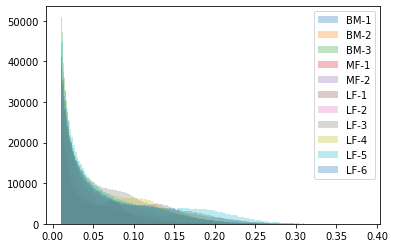

In [227]:
threshold = 0.01
fig, ax =  plt.subplots(1,1)
for model in models:
    data = []
    for i in range(6):
        temp = np.ma.array(std_db_tensors[model][i],mask = ~masks[i])
        data.append(temp[~temp.mask])
    data = np.concatenate(data)
    data = data[data > threshold]
 
    ax.hist(data, bins = 'auto', alpha = .3, label = model)
    ax.legend()
fig.show()
#fig.savefig(os.path.join('../results/Images/histograms', f'STD_Histogram_{model}.png'))
#plt.close(fig)

Dilated Histograms - WRONG

In [ ]:
threshold = .01
for model in models:
    data = []
    for i in range(6):
        dilated = cv2.erode(targets[i], np.ones((3,3),np.uint8))/255
        temp = np.ma.array(std_db_tensors[model][i],mask = dilated)
        data.append(temp[~temp.mask].data)

    data = np.concatenate(data)
    data = data[data > threshold]
    fig, ax =  plt.subplots(1,1)
    ax.hist(data, bins = 'auto')
    fig.savefig(os.path.join('../results/Images/histograms_dilated', f'STD_Dilated_Histogram_{model}.png'))
    plt.close(fig)

: 

In [258]:
    for i in range(6):
        dilated = cv2.erode(targets[i], np.ones((3,3),np.uint8))/255
        temp = np.ma.array(std_db_tensors[model][i],mask = dilated)
        data.append(temp[~temp.mask].data)

    data = np.concatenate(data)
    data = data[data > threshold]
    fig, ax =  plt.subplots(1,1)
    ax.hist(data, bins = 'auto')
    fig.savefig(os.path.join('../results/Images/histograms_dilated', f'STD_Dilated_Histogram_{model}.png'))
    plt.close(fig)

AttributeError: 'MaskedArray' object has no attribute 'append'

MSE over Base model 

In [259]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

In [260]:
# find image with highest mean squared error
real_max = 0
cur_i = 0
for i in range(5):
    cur_max = torch.nn.MSELoss()(seg_tensors['BM-1'][i], transforms.ToTensor()(targets[i]))
    print(cur_max)
    if cur_max > real_max:
        cur_i = i
        real_max = cur_max

tensor(0.0295)
tensor(0.0211)
tensor(0.0263)
tensor(0.0231)
tensor(0.0196)


In [265]:
# save an image for each model
for model in models:
    
    # one for DB
    seg = mean_db_tensors[model][cur_i][0]
    gt = TF.resize(transforms.ToTensor()(targets[cur_i]), (seg.shape[-2:]))
    n = torch.nn.MSELoss(reduction = 'none')(seg, gt)
    im = transforms.ToPILImage()(n)
    im.save(os.path.join('../results/Images/MSE_plots', f"MSE_Plot_{model + '_DB'}.png"))

    # one for Reg
    seg = seg_tensors[model][cur_i]
    gt = TF.resize(transforms.ToTensor()(targets[cur_i]), (seg.shape[-2:]))
    n = torch.nn.MSELoss(reduction = 'none')(seg, gt)
    im = transforms.ToPILImage()(n)
    im.save(os.path.join('../results/Images/MSE_plots', f'MSE_Plot_{model}.png'))

    # one for ROT
    seg = mean_rot_tensors[model][cur_i][0]
    gt = TF.resize(transforms.ToTensor()(targets[cur_i]), (seg.shape[-2:]))
    n = torch.nn.MSELoss(reduction = 'none')(seg, gt)
    im = transforms.ToPILImage()(n)
    im.save(os.path.join('../results/Images/MSE_plots', f"MSE_Plot_{model + '_ROT'}.png"))

std UQ

In [262]:
# find image with highest stddev for DB
real_max = 0
cur_i = 0
for i in range(5):
    cur_max = (std_db_tensors['BM-1'][i][0][0]).mean()
    print(cur_max)
    if cur_max > real_max:
        cur_i = i
        real_max = cur_max

tensor(0.0117)
tensor(0.0122)
tensor(0.0147)
tensor(0.0147)
tensor(0.0135)


In [268]:
# save an image for each model
for model in models:
    # ROT
    seg = std_db_tensors[model][cur_i][0]
    im = transforms.ToPILImage()(seg)
    im.save(os.path.join('../results/Images/STD_plots', f"STD_Plot_{model + '_ROT'}.png"))
    # DB
    seg = std_db_tensors[model][cur_i][0]
    im = transforms.ToPILImage()(seg)
    im.save(os.path.join('../results/Images/STD_plots', f"STD_Plot_{model + '_DB'}.png"))

In [ ]:
# save a scaled image for each model
for model in models:
    # ROT
    seg = std_db_tensors[model][cur_i][0] * 3
    im = transforms.ToPILImage()(seg)
    im.save(os.path.join('../results/Images/STD_plots_scaled', f"STD_Plot_{model + '_ROT'}.png"))
    # DB
    seg = std_db_tensors[model][cur_i][0] * 3
    im = transforms.ToPILImage()(seg)
    im.save(os.path.join('../results/Images/STD_plots_scaled', f"STD_Plot_{model + '_DB'}.png"))